In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot

In [2]:
# Accessing MNIST dataset with tensorflow
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images, test_images = training_images / 255.0, test_images / 255.0

In [3]:
def relu(x):
    return np.maximum(0, x)

In [4]:
def relu_deriv(x):
    return np.where(x < 0, 0, 1)

In [5]:
def display_images(images, labels, num_images = 10):
    figure, axes = plot.subplots(1, num_images, figsize = (20, 2)) # 1 row, num_images number of columns
    for i in range(num_images):
        axes[i].imshow(images[i], cmap = 'gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plot.tight_layout()
    plot.show()

In [6]:
class Perceptron():
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(layer_sizes[i + 1], layer_sizes[i]) for i in range(len(layer_sizes) - 1)]    # creates list of matrices
        self.biases = [np.random.rand(layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]                      # i+1 because biases needed only for layers after input layer
        self.weighted_sums = [np.zeros(layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]                     # i+1 for same reason as above
        self.activations = [np.zeros(layer_sizes[i]) for i in range(len(layer_sizes))]                               # len(layer_sizes) because activations for all layers (input, hidden, and output) stored
    
    def forward_propagate(self, input_activations):                                               # input_activations is a vector
        self.activations[0] = input_activations.flatten()                                         # Initialises the input activations as first element in a list of activations for each layer
        for i in range(len(self.layer_sizes) - 1):
            self.weighted_sums[i] = np.dot(self.weights[i], self.activations[i]) + self.biases[i]       # This layer's weight minus previous layer's activation + this layer's bias   
            self.activations[i + 1] = relu(self.weighted_sums[i])                                       # i+1 because activations includes input layer wheareas others don't; ideally for readability, activations index would be 1 less than weights and biases 
    
    def calculate_cost(self, desired_activations):                                                  # Calculates cost of one image
        return np.sum(np.square(self.activations[-1] - desired_activations) / 2)

    def back_propagate(self, desired_activations):          # Calculates gradients for weights and biases
        weights_gradient = [np.zeros((self.layer_sizes[i + 1], self.layer_sizes[i])) for i in range(len(self.layer_sizes) - 1)]       # Same shape as weights
        biases_gradient = [np.zeros(self.layer_sizes[i + 1]) for i in range(len(self.layer_sizes) - 1)]
        error = self.activations[-1] - desired_activations

        for i in range(len(self.layer_sizes) - 2, -1, -1):                   # Iterates from last layer to first layer                                          # Iterate through layers, starting out output layer
            weights_gradient = np.dot(error.reshape(-1, 1), self.activations[i].reshape(1, -1)) * relu_deriv(self.weighted_sums[i].reshape(-1, 1))              # Should result in a matrix (first, dot product between a row and column vector, then element-wise multiplication)
            biases_gradient = relu_deriv(self.weighted_sums[i]) * error
        
        return weights_gradient, biases_gradient
        
    def adjust_parameters(self, mean_weights_gradient, mean_biases_gradient, learning_rate):       # Shift weights and biases according to gradient
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] -= learning_rate * mean_weights_gradient[i]
            self.biases[i] -= learning_rate * mean_biases_gradient[i]

    def test_model(self):
        incorrect_classifications = 0
        for i in range(100):
            desired_activations = np.zeros(self.layer_sizes[-1])                    # Initialises a vector with the size of the number of output nodes
            desired_activations[test_labels[i]] = 1.0
            
            self.forward_propagate(test_images[i])
            if np.argmax(self.activations[-1]) != test_labels[i]:
                incorrect_classifications += 1
        
        return incorrect_classifications

In [7]:
LAYER_SIZES = [784, 10]
NUM_TRAINING_IMAGES = 30000
LEARNING_RATE = 0.1
BATCH_SIZE = 1000

In [8]:
perceptron = Perceptron(LAYER_SIZES)

sample_weights_gradient = [np.zeros((LAYER_SIZES[i + 1], LAYER_SIZES[i])) for i in range(len(LAYER_SIZES) - 1)]             # Same shape as weights
sample_biases_gradient = [np.zeros(LAYER_SIZES[i + 1]) for i in range(len(LAYER_SIZES) - 1)]
mean_weights_gradient = [np.zeros((LAYER_SIZES[i + 1], LAYER_SIZES[i])) for i in range(len(LAYER_SIZES) - 1)]       # Same shape as weights
mean_biases_gradient = [np.zeros(LAYER_SIZES[i + 1]) for i in range(len(LAYER_SIZES) - 1)]

total_cost = 0
new_cost = 0
percentage_error = []

In [9]:
for i in range(NUM_TRAINING_IMAGES):
    perceptron.forward_propagate(training_images[i])

    desired_activations = np.zeros(LAYER_SIZES[-1])                    # Initialises a vector with the size of the number of output nodes
    desired_activations[training_labels[i]] = 1.0

    total_cost += perceptron.calculate_cost(desired_activations)

    sample_weights_gradient, sample_biases_gradient = perceptron.back_propagate(desired_activations)

    for j in range(len(LAYER_SIZES) - 1):                           # For each layer apart from input layer, iteratively update mean gradient
        mean_weights_gradient[j] += sample_weights_gradient[j] / NUM_TRAINING_IMAGES
        mean_biases_gradient[j] += sample_biases_gradient[j] / NUM_TRAINING_IMAGES
    
    if i % BATCH_SIZE == 0:
        perceptron.adjust_parameters(mean_weights_gradient, mean_biases_gradient, LEARNING_RATE)
        percentage_error.append(perceptron.test_model())

In [10]:
#for i in range(len(LAYER_SIZES) - 1):
    #mean_weights_gradient[i] /= NUM_TRAINING_IMAGES
    #mean_biases_gradient[i] /= NUM_TRAINING_IMAGES

In [11]:
#perceptron.adjust_parameters(mean_weights_gradient, mean_biases_gradient, LEARNING_RATE)

In [12]:
for i in range(NUM_TRAINING_IMAGES):
    desired_activations = np.zeros(LAYER_SIZES[-1])                    # Initialises a vector with the size of the number of output nodes
    desired_activations[training_labels[i]] = 1.0
    new_cost += perceptron.calculate_cost(desired_activations)

In [13]:
print("Cost: " + str(total_cost))
print("New Cost: " + str(new_cost))

Cost: 1660881.3976690355
New Cost: 15000.0


0
0
0
0
0
0
0
0
0
0


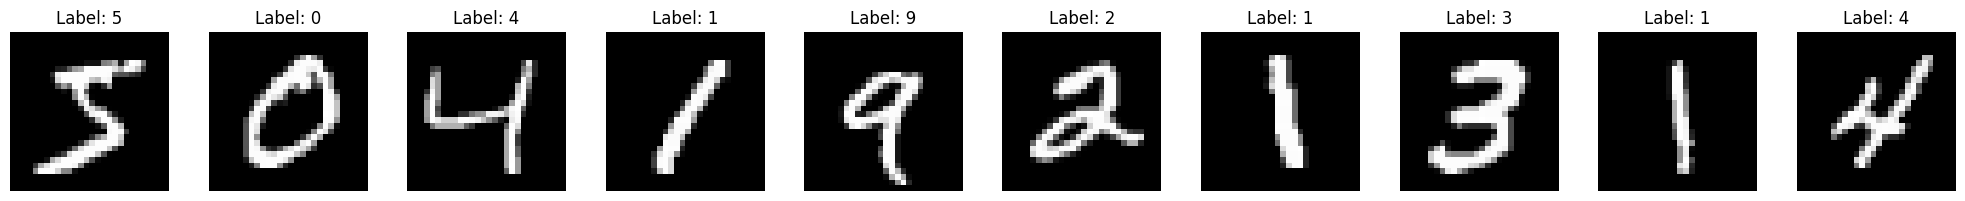

In [14]:
for i in range(10):
    perceptron.forward_propagate(training_images[i])
    print(np.argmax(perceptron.activations[-1]))

display_images(training_images, training_labels)

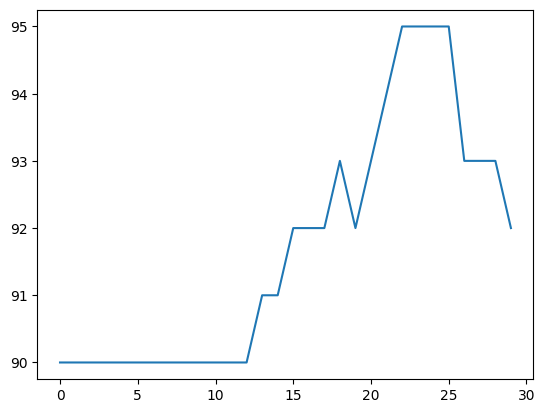

In [15]:
plot.plot(percentage_error)